# Análisis Comparativo de Modelos LLM
## Evaluación de Comprensión de Modismos Colombianos

Este notebook presenta visualizaciones para comparar el desempeño de diferentes modelos LLM en la comprensión de modismos colombianos usando múltiples métricas:

- **BERTScore (BETO & SciBETO)**: Similitud semántica con embeddings contextuales
- **Sentence-BERT**: Similitud basada en embeddings de oraciones
- **chrF**: Similitud a nivel de caracteres (n-gramas)
- **Accuracy**: Clasificación binaria

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Directorio de resultados
RESULTS_DIR = Path('Metricas LLM/Metricas_Resultados')
RANKING_OUTPUT_DIR = Path('Metricas LLM/Ranking_Resultados')
RANKING_OUTPUT_DIR.mkdir(exist_ok=True)

## Carga de Datos

Cargamos todos los resultados de las métricas y los consolidamos en DataFrames para análisis.

In [7]:
def load_json_results(filename):
    """Carga un archivo JSON de resultados"""
    filepath = RESULTS_DIR / filename
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

# Cargar todos los resultados
# PROMPT 1: Modismo → Definición
p1_beto = pd.DataFrame(load_json_results('prompt_1_beto_bertscore_resultados.json'))
p1_scibeto = pd.DataFrame(load_json_results('prompt_1_scibeto_bertscore_resultados.json'))
p1_sbert = pd.DataFrame(load_json_results('prompt_1_sbert_similarity_resultados.json'))
p1_chrf = pd.DataFrame(load_json_results('prompt_1_chrf_resultados.json'))

# PROMPT 2: ¿Es Modismo?
p2_accuracy = pd.DataFrame(load_json_results('prompt_2_accuracy_resultados.json'))

# PROMPT 3: Modismo + Ejemplo → Literal + Definición
p3_beto = pd.DataFrame(load_json_results('prompt_3_beto_bertscore_resultados.json'))
p3_scibeto = pd.DataFrame(load_json_results('prompt_3_scibeto_bertscore_resultados.json'))
p3_sbert = pd.DataFrame(load_json_results('prompt_3_sbert_similarity_resultados.json'))
p3_chrf = pd.DataFrame(load_json_results('prompt_3_chrf_resultados.json'))

## Visualización 1: Desempeño por Métrica Individual

Gráficas separadas para cada métrica, ordenadas del mejor al peor modelo.

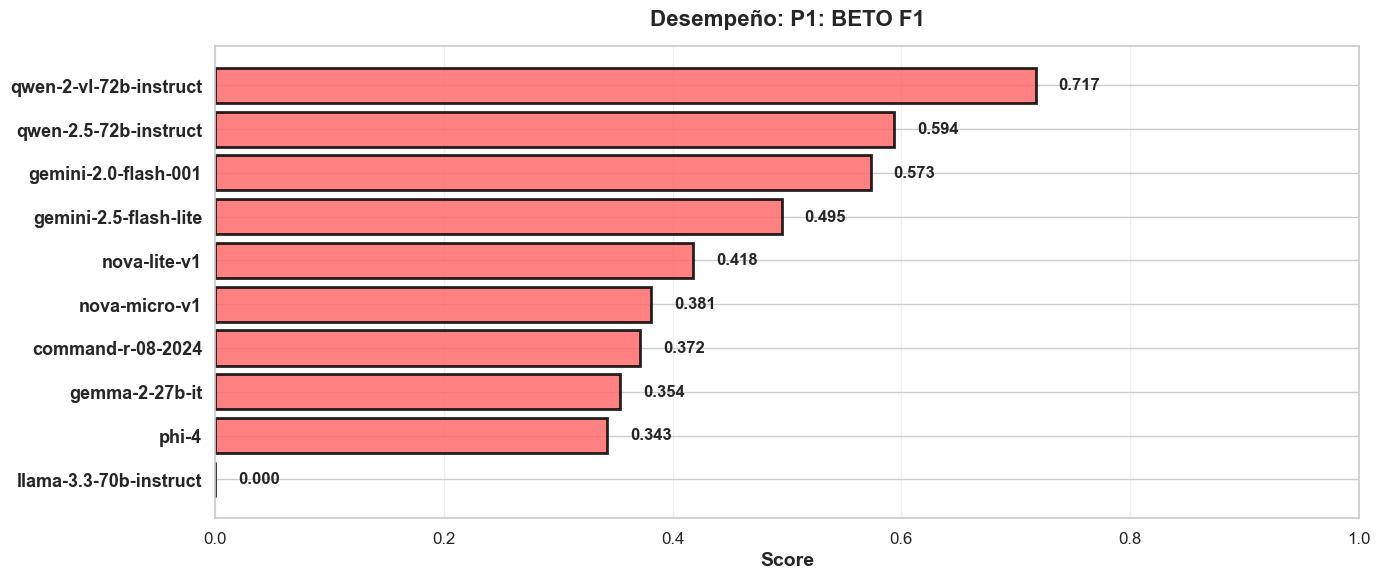

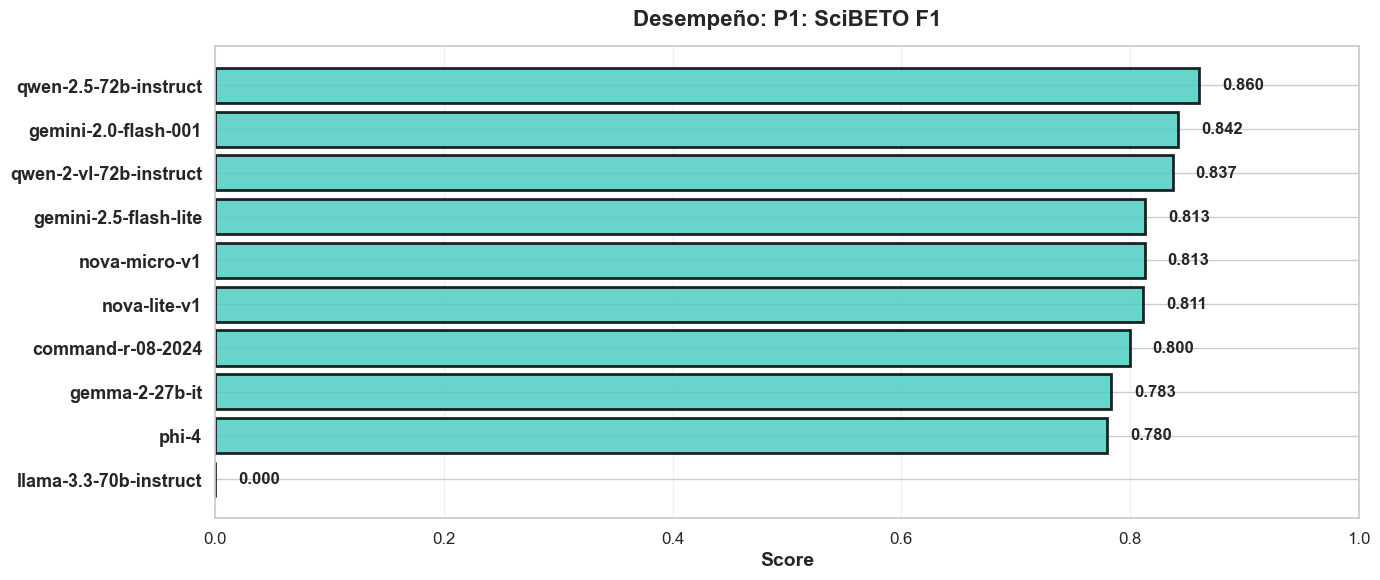

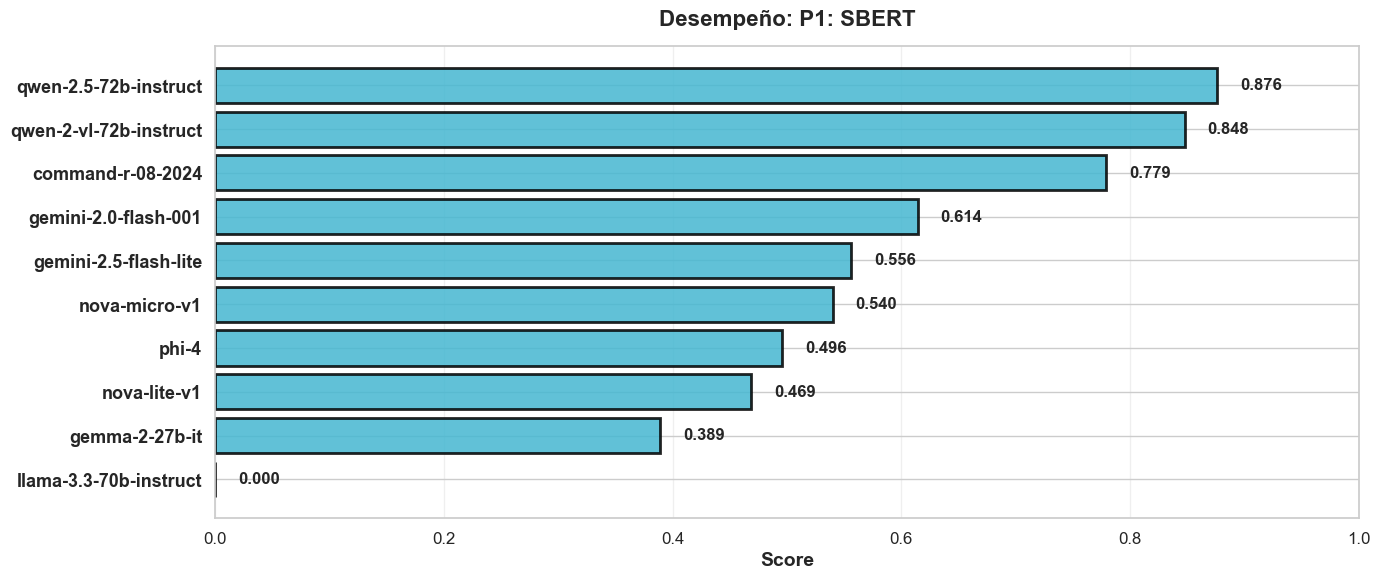

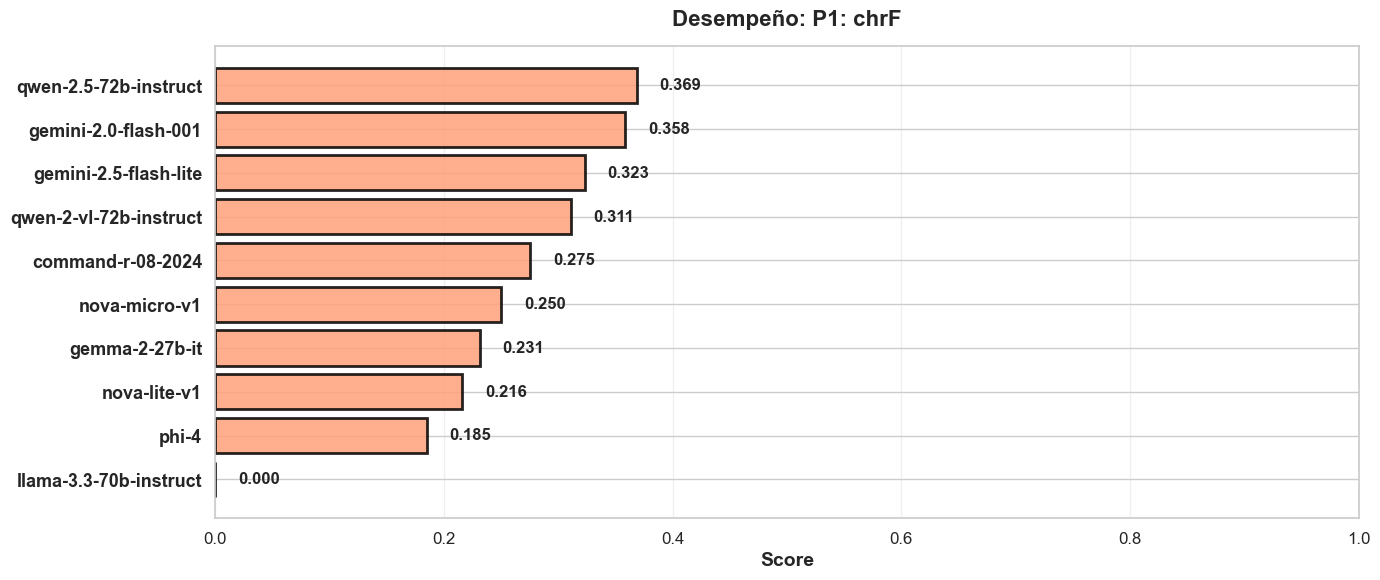

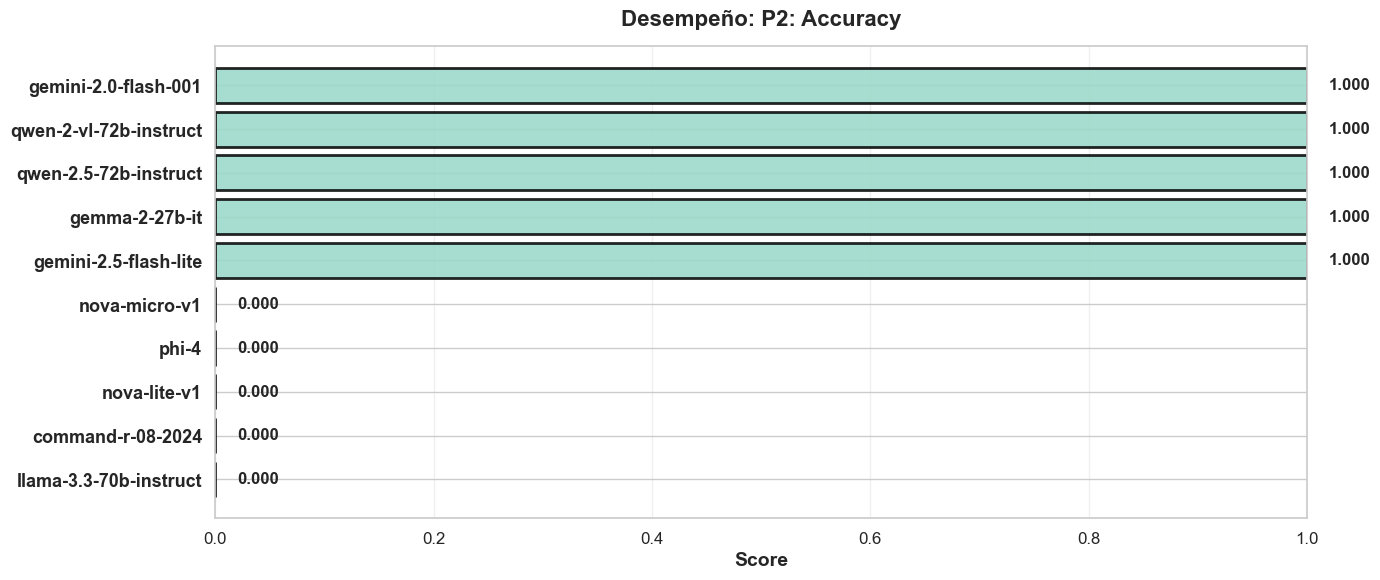

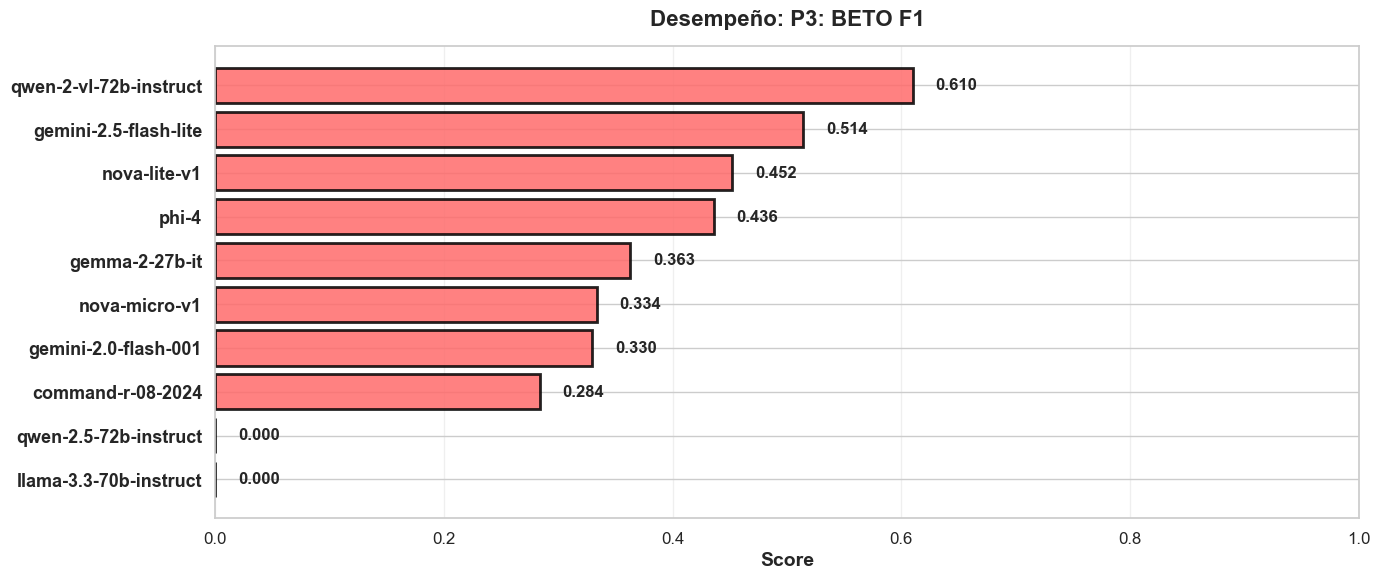

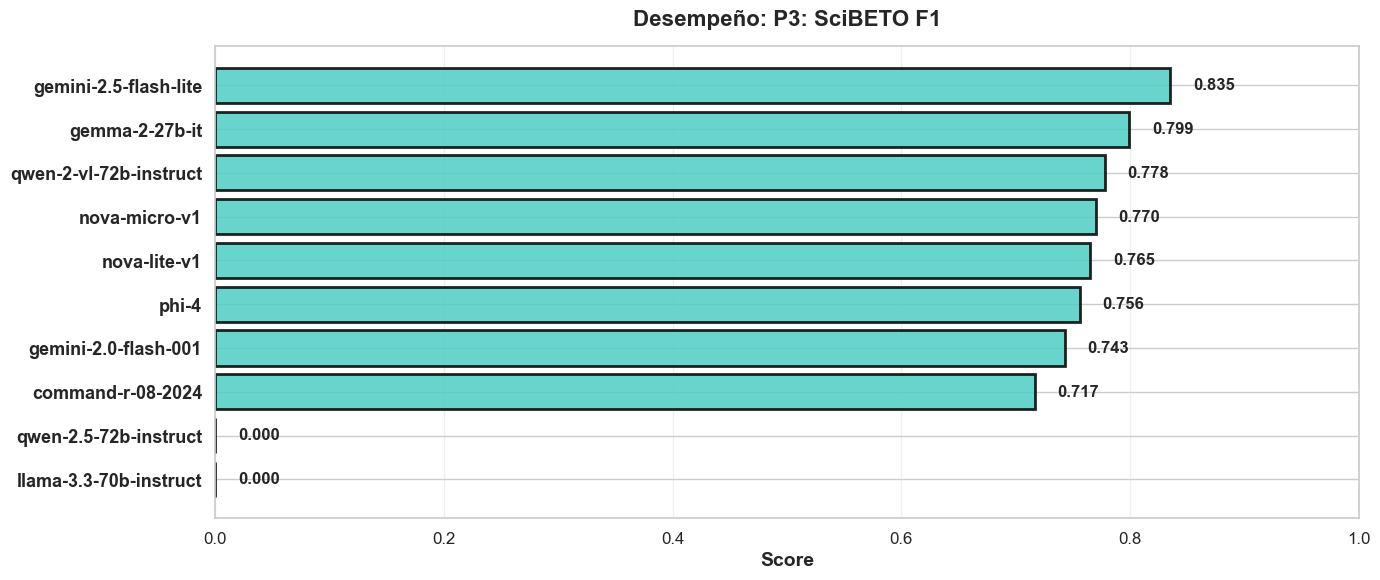

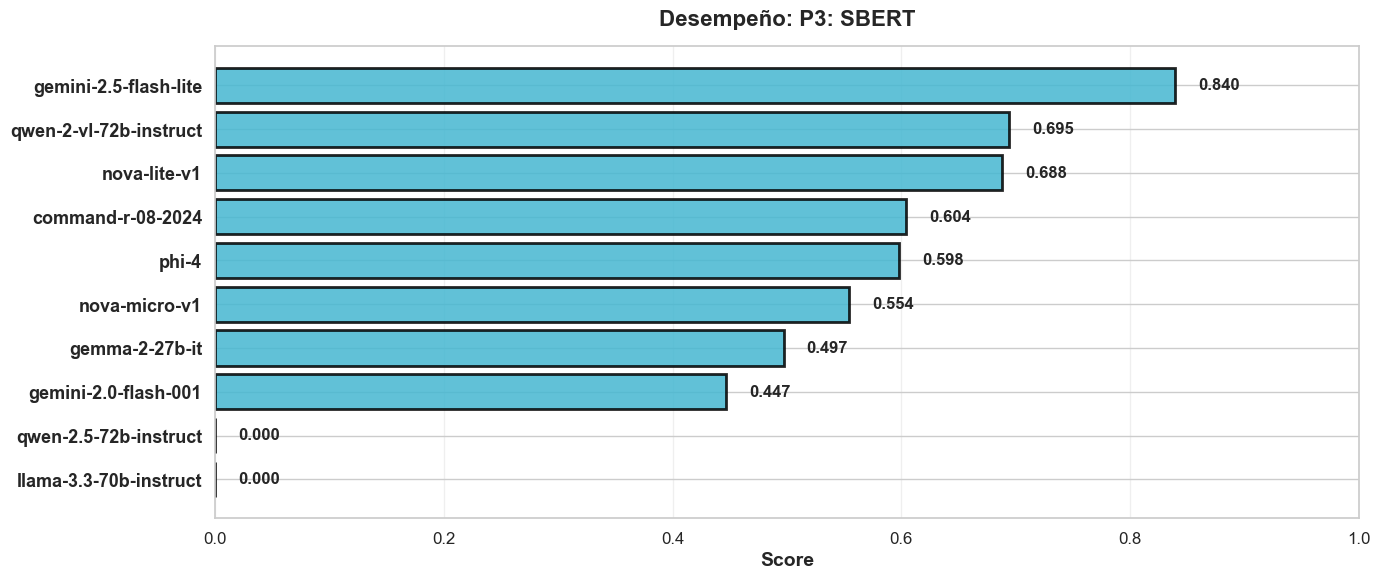

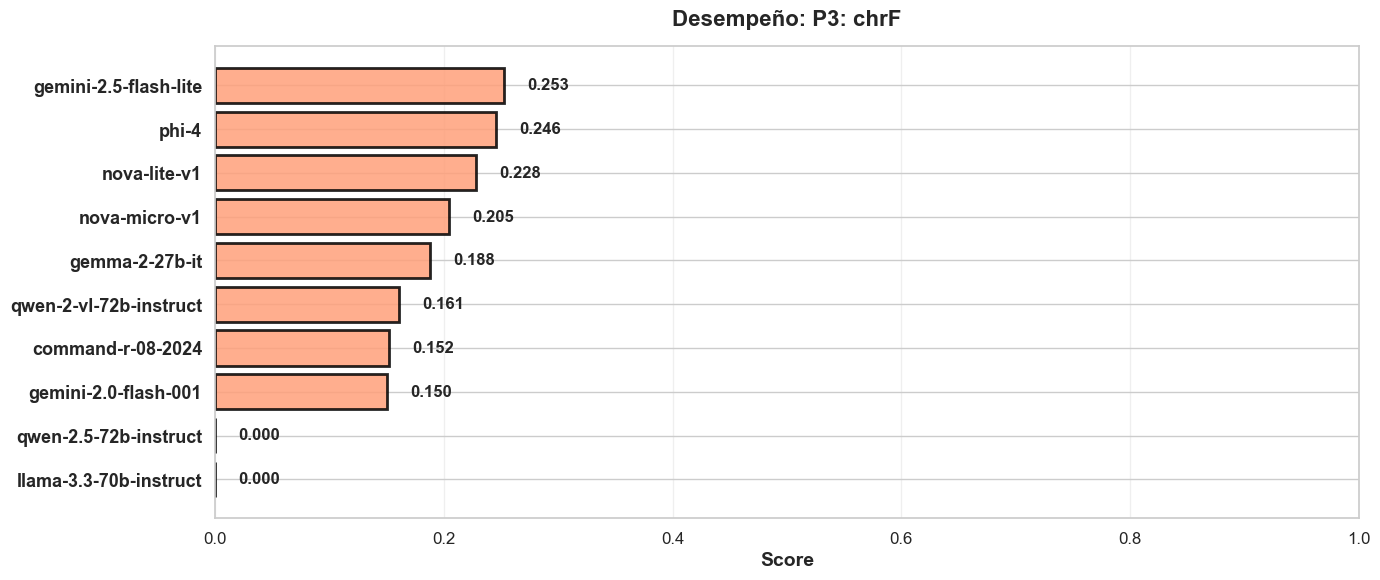

In [8]:
# Consolidar métricas promedio por modelo
metrics_data = {}

for modelo in p1_beto['modelo'].unique():
    modelo_short = modelo.split('/')[-1]
    
    metrics_data[modelo_short] = {
        'P1: BETO F1': p1_beto[p1_beto['modelo'] == modelo]['f1_score'].mean(),
        'P1: SciBETO F1': p1_scibeto[p1_scibeto['modelo'] == modelo]['f1_score'].mean(),
        'P1: SBERT': p1_sbert[p1_sbert['modelo'] == modelo]['similarity'].mean(),
        'P1: chrF': p1_chrf[p1_chrf['modelo'] == modelo]['chrf_score'].mean(),
        'P2: Accuracy': p2_accuracy[p2_accuracy['modelo'] == modelo]['correcto'].mean(),
        'P3: BETO F1': p3_beto[p3_beto['modelo'] == modelo]['f1_score'].mean(),
        'P3: SciBETO F1': p3_scibeto[p3_scibeto['modelo'] == modelo]['f1_score'].mean(),
        'P3: SBERT': p3_sbert[p3_sbert['modelo'] == modelo]['similarity'].mean(),
        'P3: chrF': p3_chrf[p3_chrf['modelo'] == modelo]['chrf_score'].mean()
    }

# Crear 9 gráficas separadas (una por métrica) - CADA UNA EN SU PROPIA FIGURA
metric_names = list(list(metrics_data.values())[0].keys())
colors_palette = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', 
                  '#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, metric_name in enumerate(metric_names):
    # Crear figura individual para cada métrica
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Crear DataFrame para esta métrica y ordenar
    metric_df = pd.DataFrame([
        {'Modelo': modelo, 'Score': scores[metric_name]} 
        for modelo, scores in metrics_data.items()
    ])
    metric_df = metric_df.sort_values('Score', ascending=False)
    
    # Crear barras
    bars = ax.barh(range(len(metric_df)), metric_df['Score'], 
                   color=colors_palette[idx], edgecolor='black', linewidth=2, alpha=0.85)
    
    # Configurar ejes
    ax.set_yticks(range(len(metric_df)))
    ax.set_yticklabels(metric_df['Modelo'], fontsize=13, fontweight='bold')
    ax.set_xlabel('Score', fontweight='bold', fontsize=14)
    ax.set_title(f'Desempeño: {metric_name}', fontweight='bold', fontsize=16, pad=15)
    ax.set_xlim(0, 1.0)
    ax.grid(True, alpha=0.3, axis='x')
    ax.invert_yaxis()
    
    # Añadir valores al final de cada barra
    for i, (bar, score) in enumerate(zip(bars, metric_df['Score'])):
        ax.text(score + 0.02, i, f'{score:.3f}', 
                va='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    # plt.savefig(RANKING_OUTPUT_DIR / f'metrica_{idx+1}_{metric_name.replace(":", "").replace(" ", "_")}.png', 
    #             dpi=300, bbox_inches='tight')
    plt.show()

## Visualización 2: Radar Chart - Perfil Multimétrica

Comparación visual del perfil de cada modelo en todas las dimensiones evaluadas.

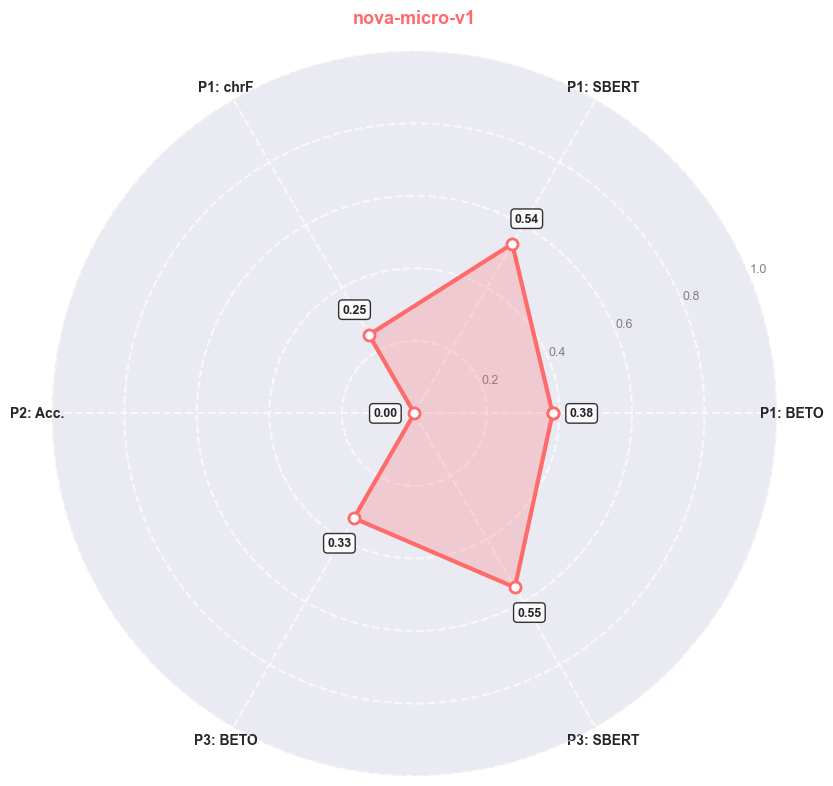

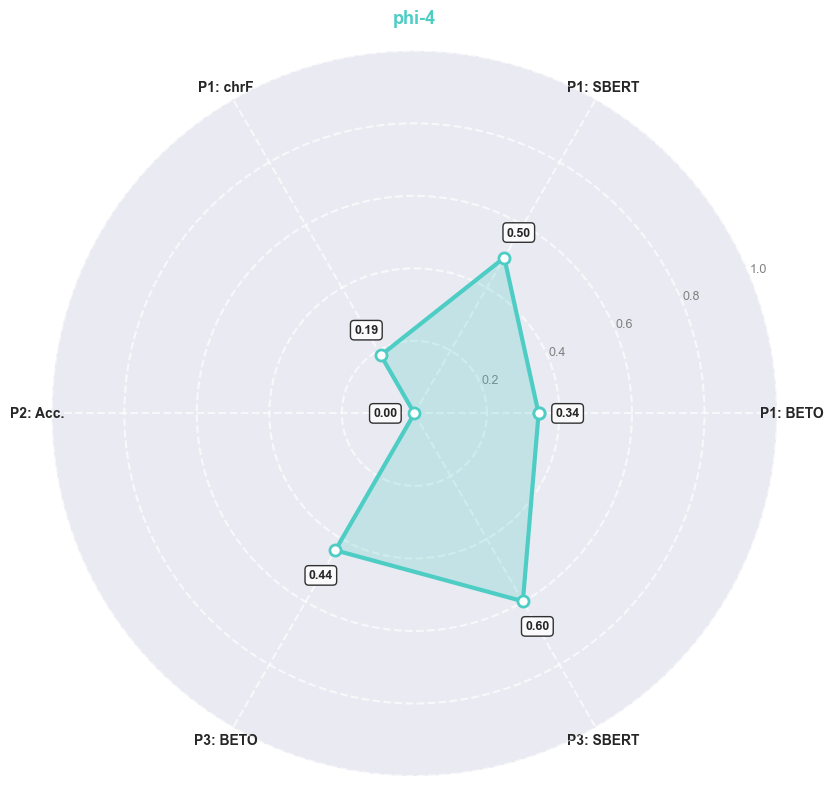

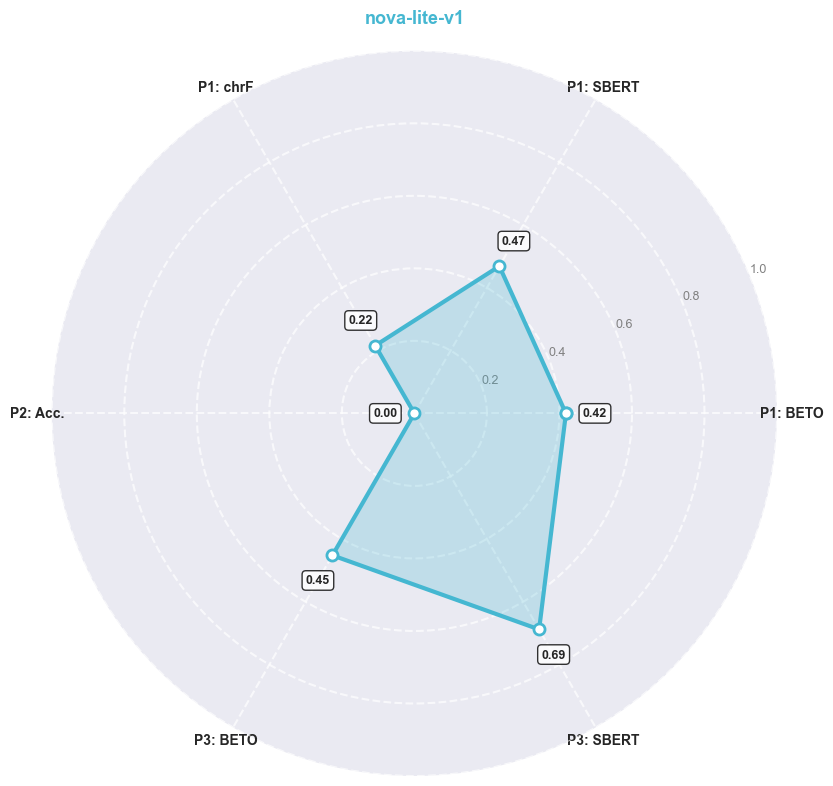

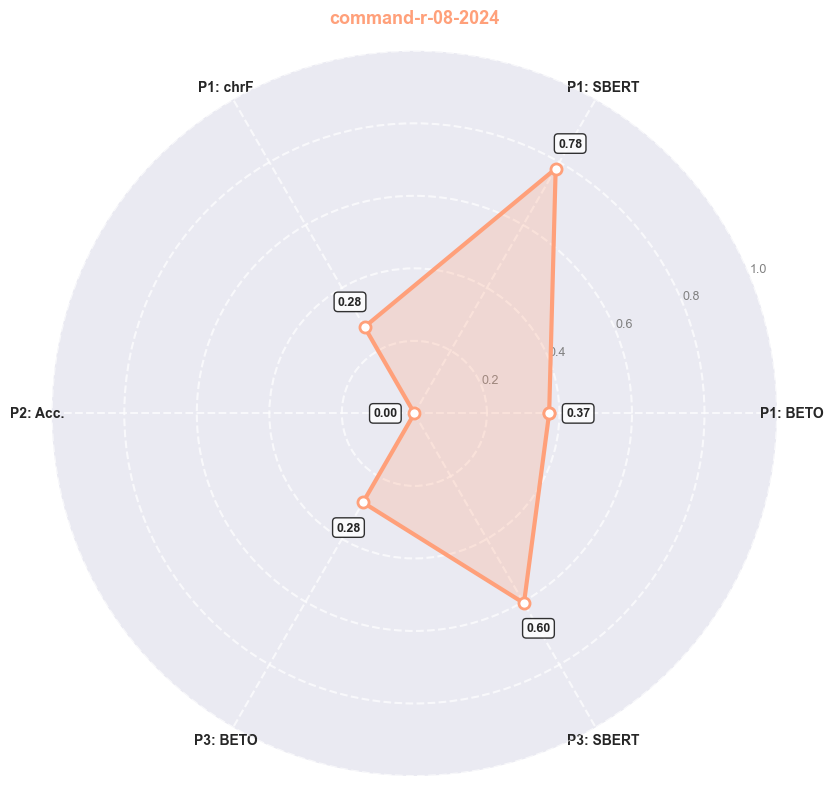

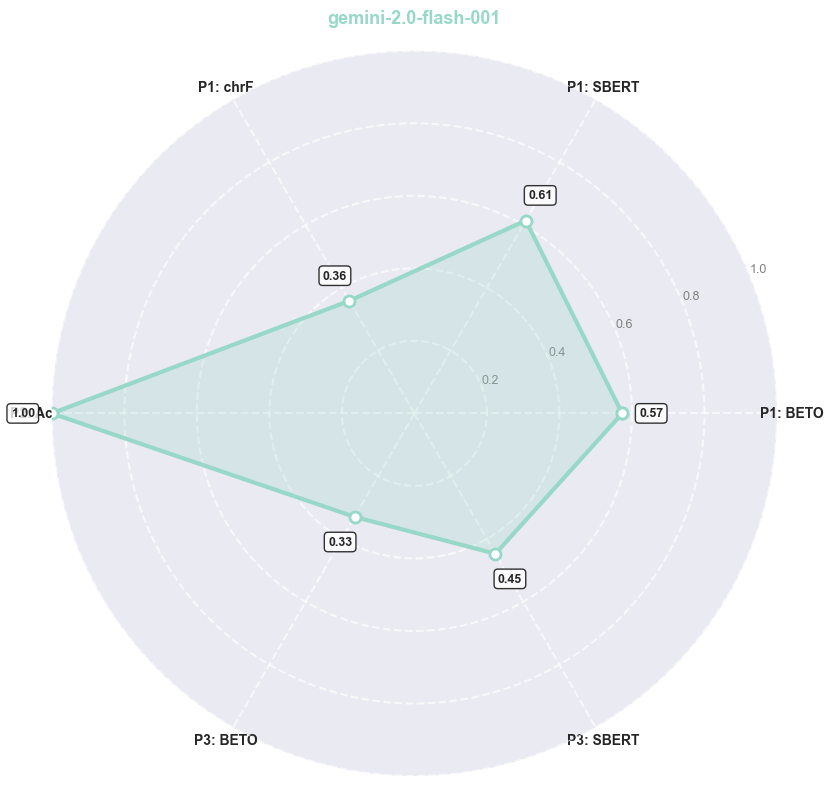

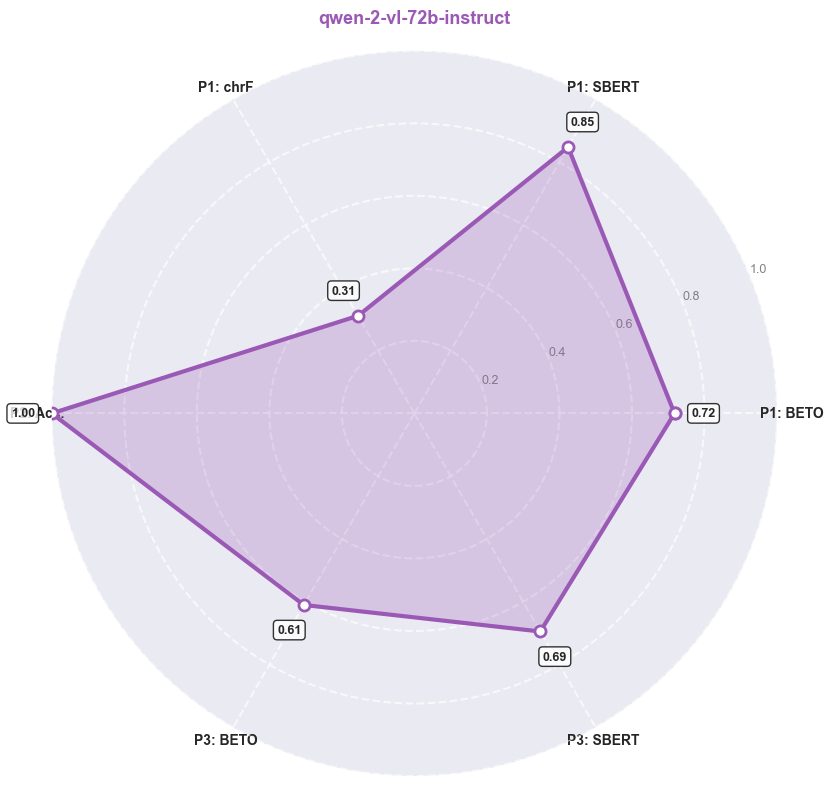

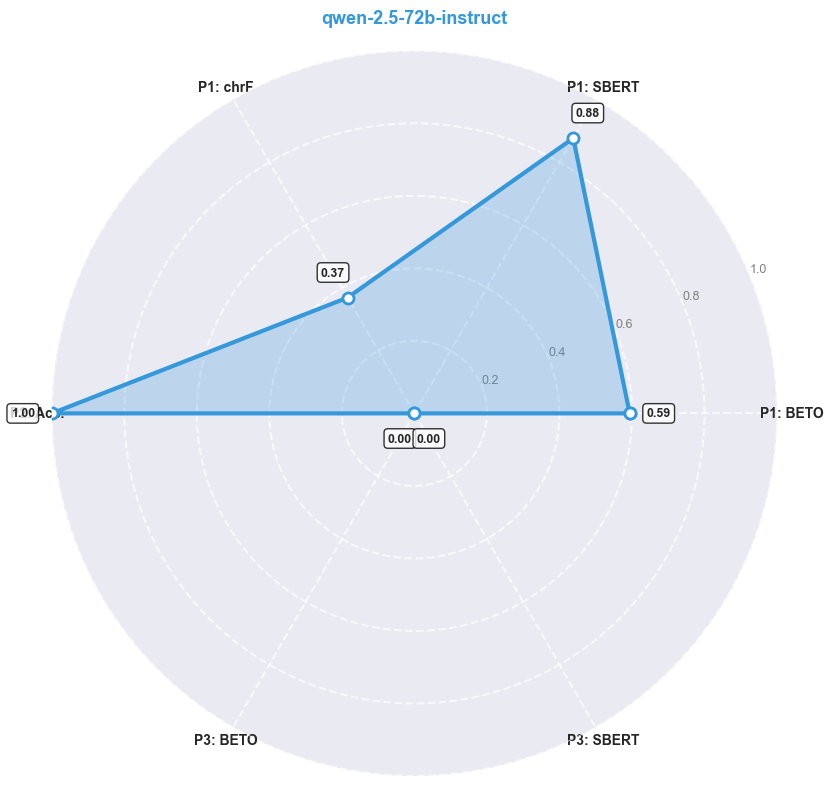

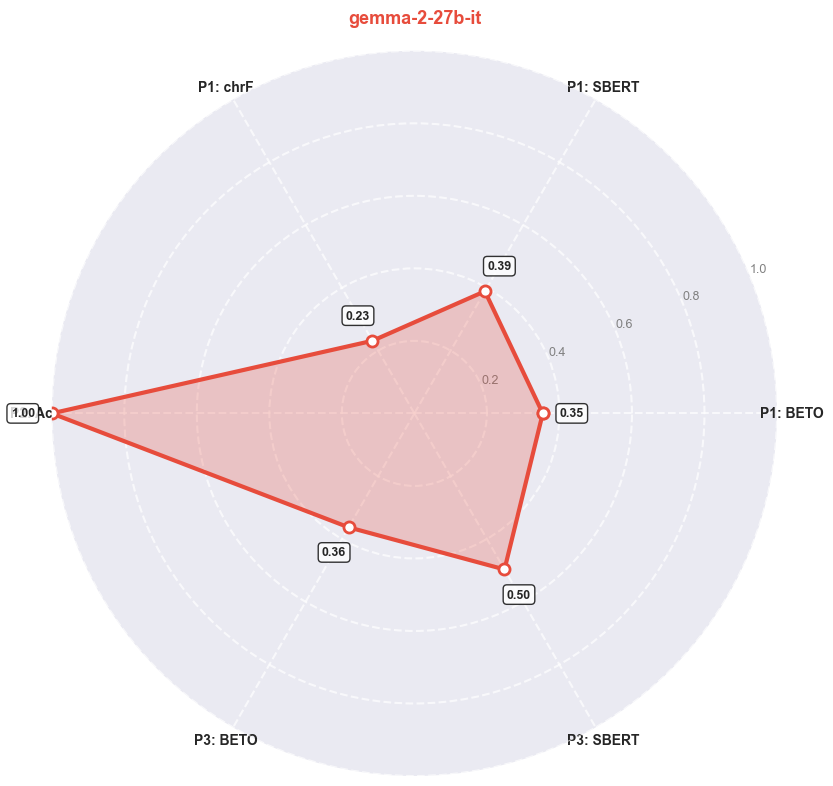

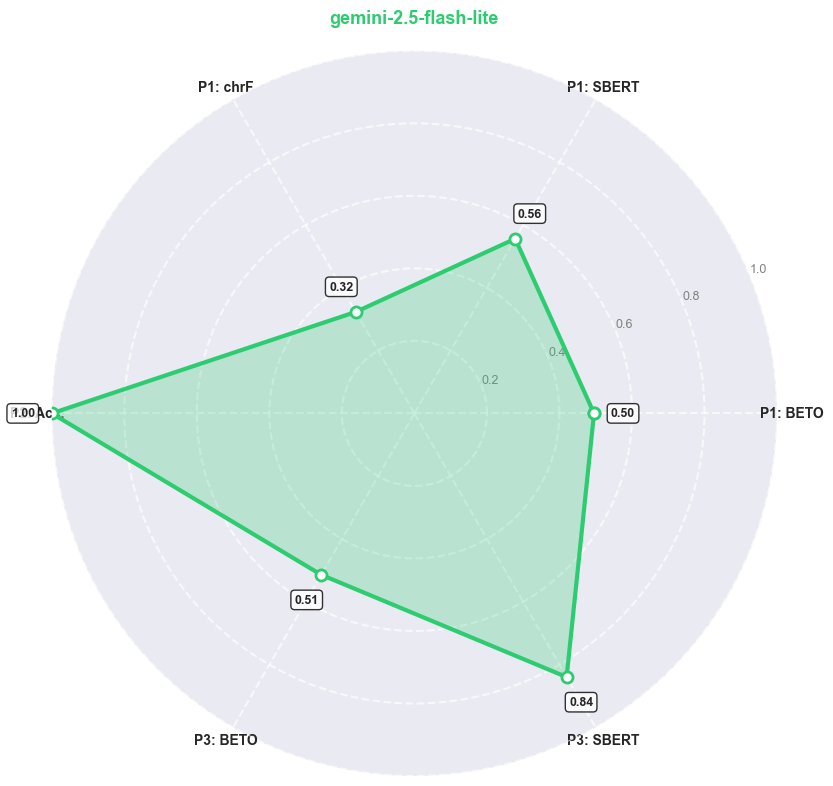

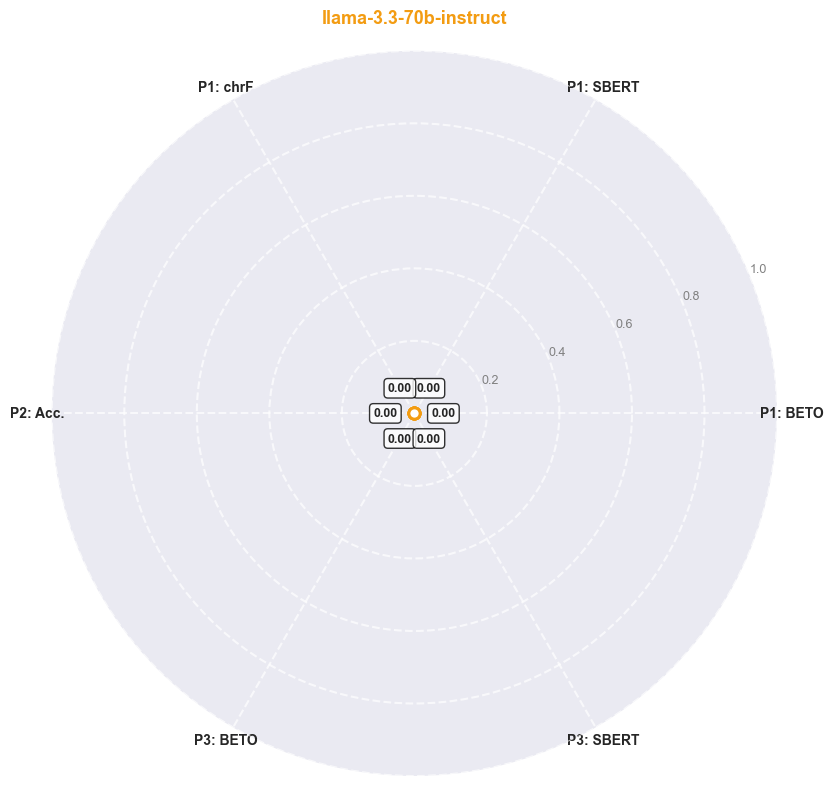

In [4]:
from math import pi

# Seleccionar métricas clave para el radar
radar_metrics = ['P1: BETO F1', 'P1: SBERT', 'P1: chrF', 'P2: Accuracy', 'P3: BETO F1', 'P3: SBERT']
radar_labels = ['P1: BETO', 'P1: SBERT', 'P1: chrF', 'P2: Acc.', 'P3: BETO', 'P3: SBERT']

# Preparar datos para radar
radar_data = {}
for modelo_short, scores in metrics_data.items():
    radar_data[modelo_short] = [scores[metric] for metric in radar_metrics]

# Número de variables
num_vars = len(radar_metrics)

# Calcular ángulos para cada eje
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Crear una figura individual para cada modelo
model_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', 
                '#9B59B6', '#3498DB', '#E74C3C', '#2ECC71', '#F39C12']

for idx, (modelo_short, values) in enumerate(radar_data.items()):
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))
    
    values_plot = values + values[:1]
    
    # Dibujar línea y rellenar
    ax.plot(angles, values_plot, 'o-', linewidth=3, 
            color=model_colors[idx % len(model_colors)], 
            markersize=8, markerfacecolor='white', markeredgewidth=2)
    ax.fill(angles, values_plot, alpha=0.25, color=model_colors[idx % len(model_colors)])
    
    # Configurar ejes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_labels, size=10, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=9, color='gray')
    ax.grid(True, linestyle='--', alpha=0.7, linewidth=1.5)
    
    # Añadir valores en cada punto
    for angle, value, label in zip(angles[:-1], values, radar_labels):
        ax.text(angle, value + 0.08, f'{value:.2f}', 
                ha='center', va='center', size=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Título individual para cada modelo
    ax.set_title(f'{modelo_short}', size=13, fontweight='bold', pad=20,
                 color=model_colors[idx % len(model_colors)])

    # Guardar figura individual
    plt.tight_layout()
    # plt.savefig(RANKING_OUTPUT_DIR / f'radar_chart_{modelo_short.replace("/", "_")}.png', 
    #             dpi=300, bbox_inches='tight')
    plt.show()

## Visualización 3: Distribución de Scores por Métrica

Gráficas separadas mostrando distribución completa de cada métrica.

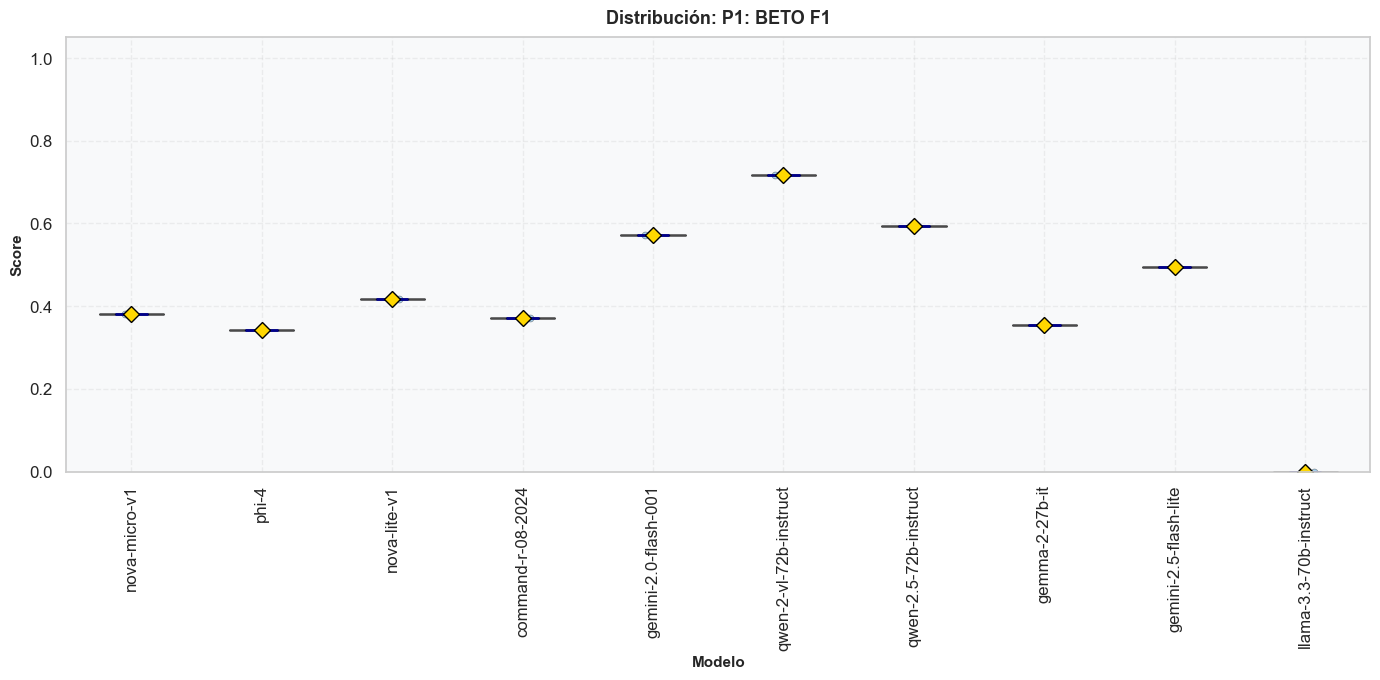

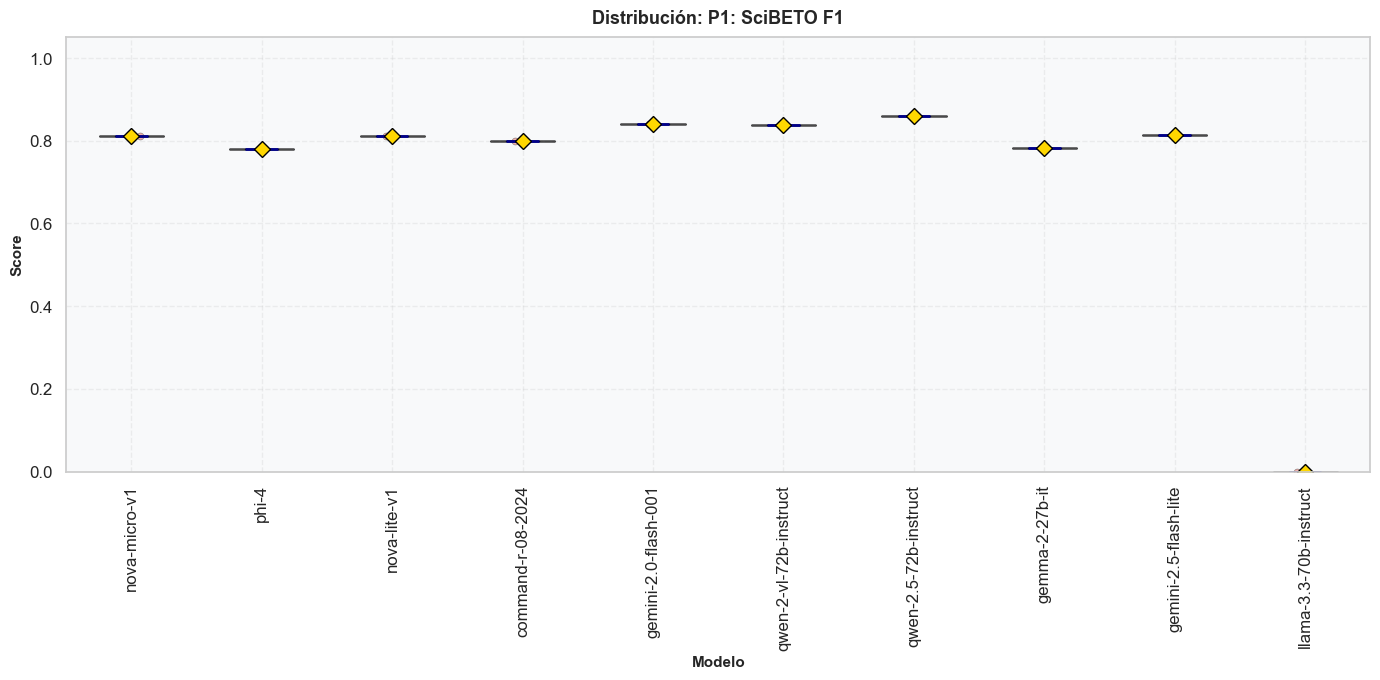

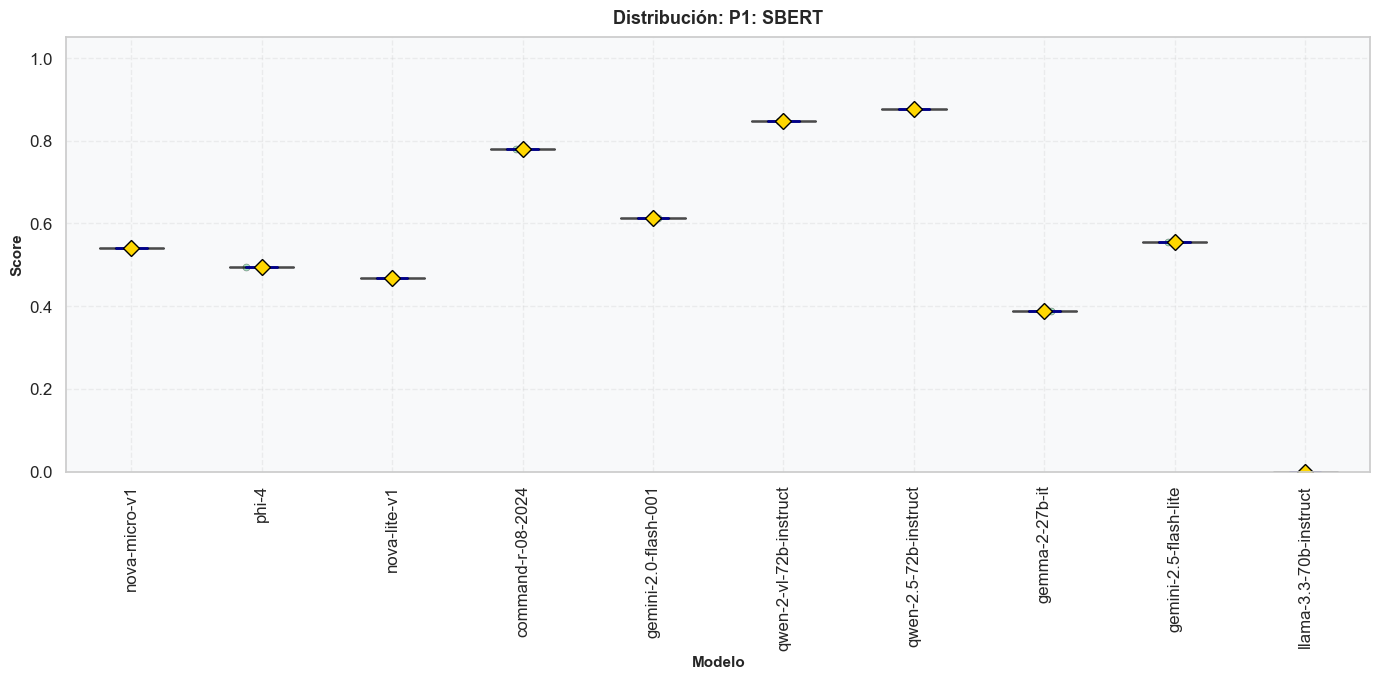

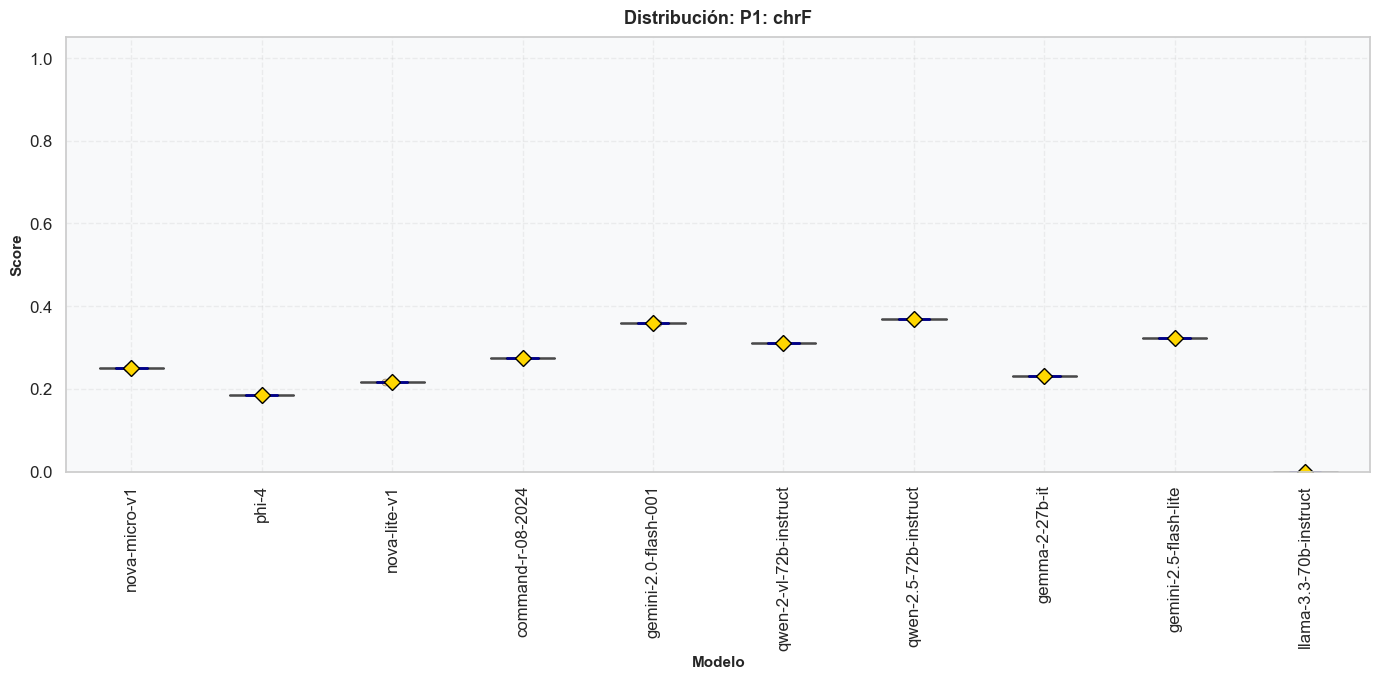

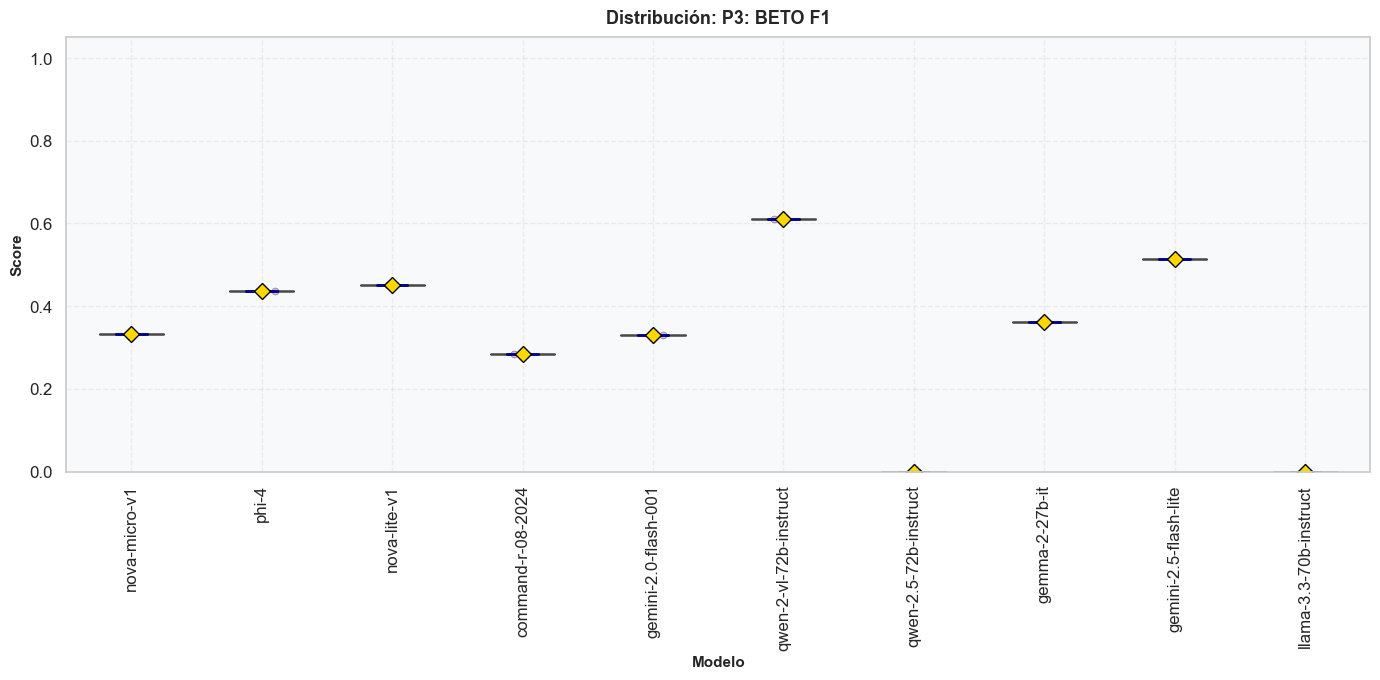

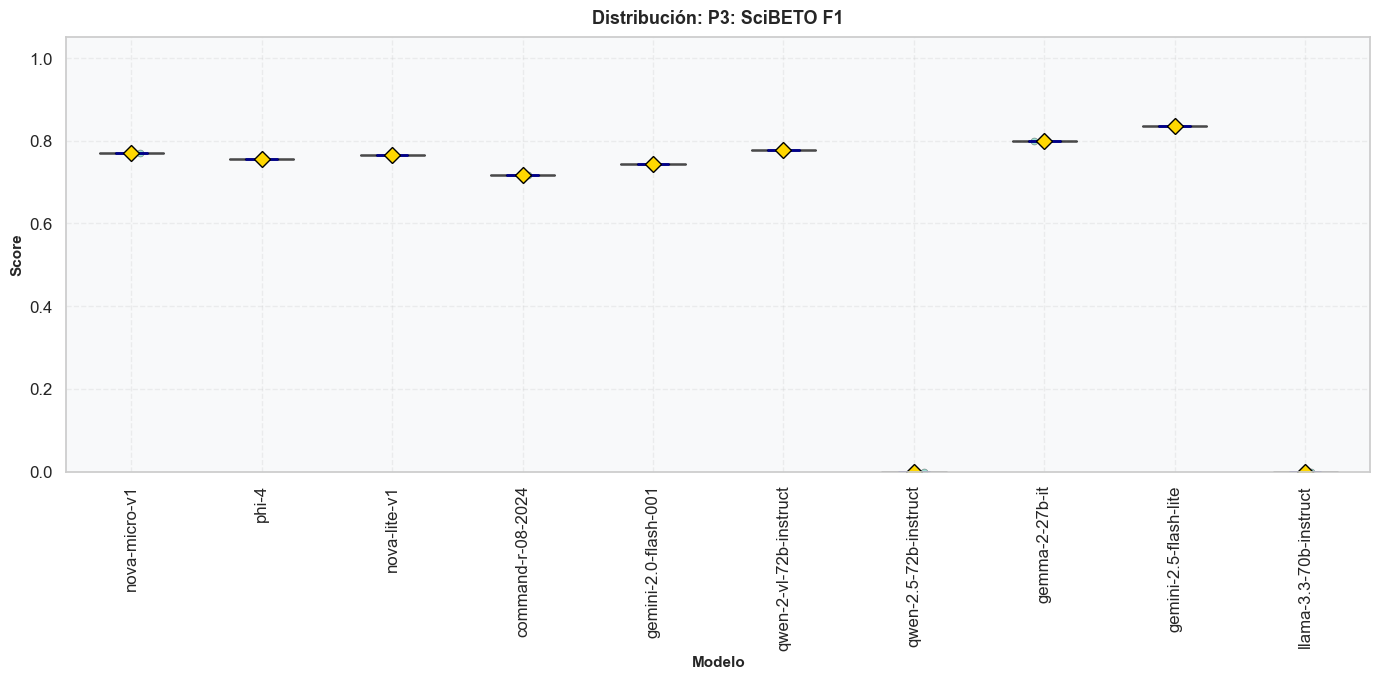

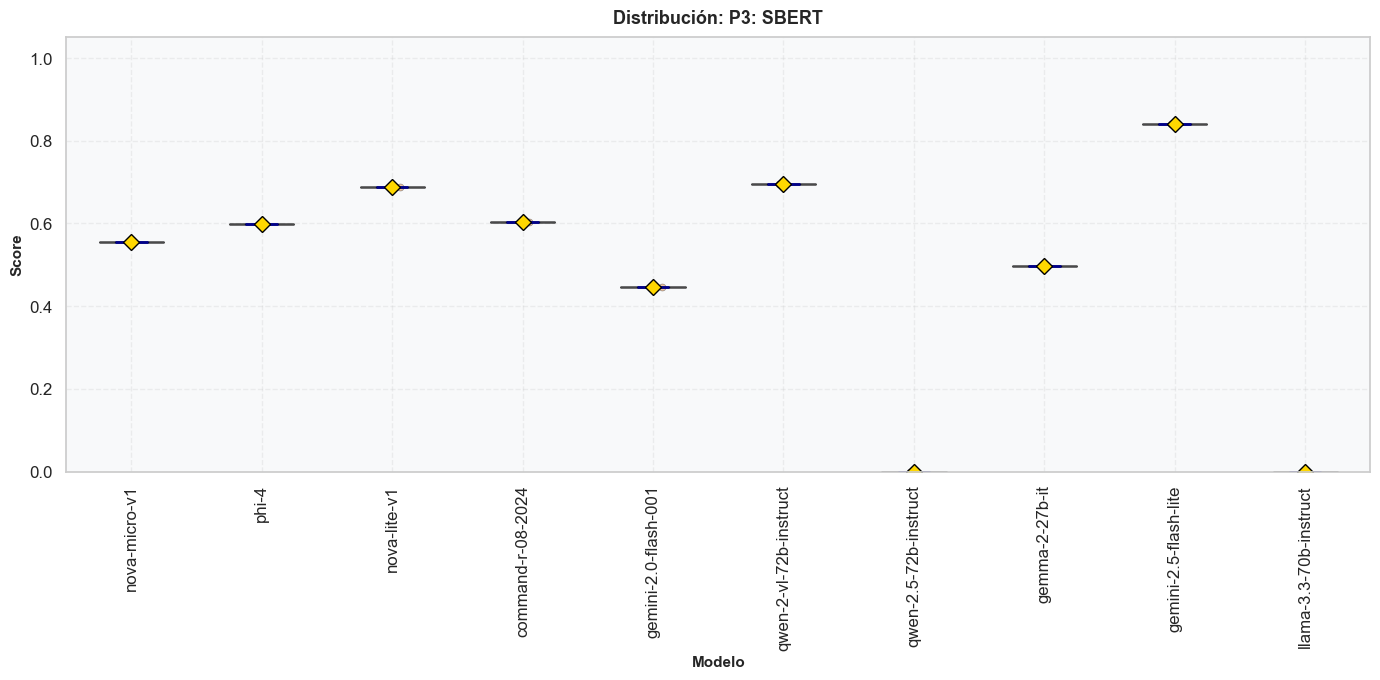

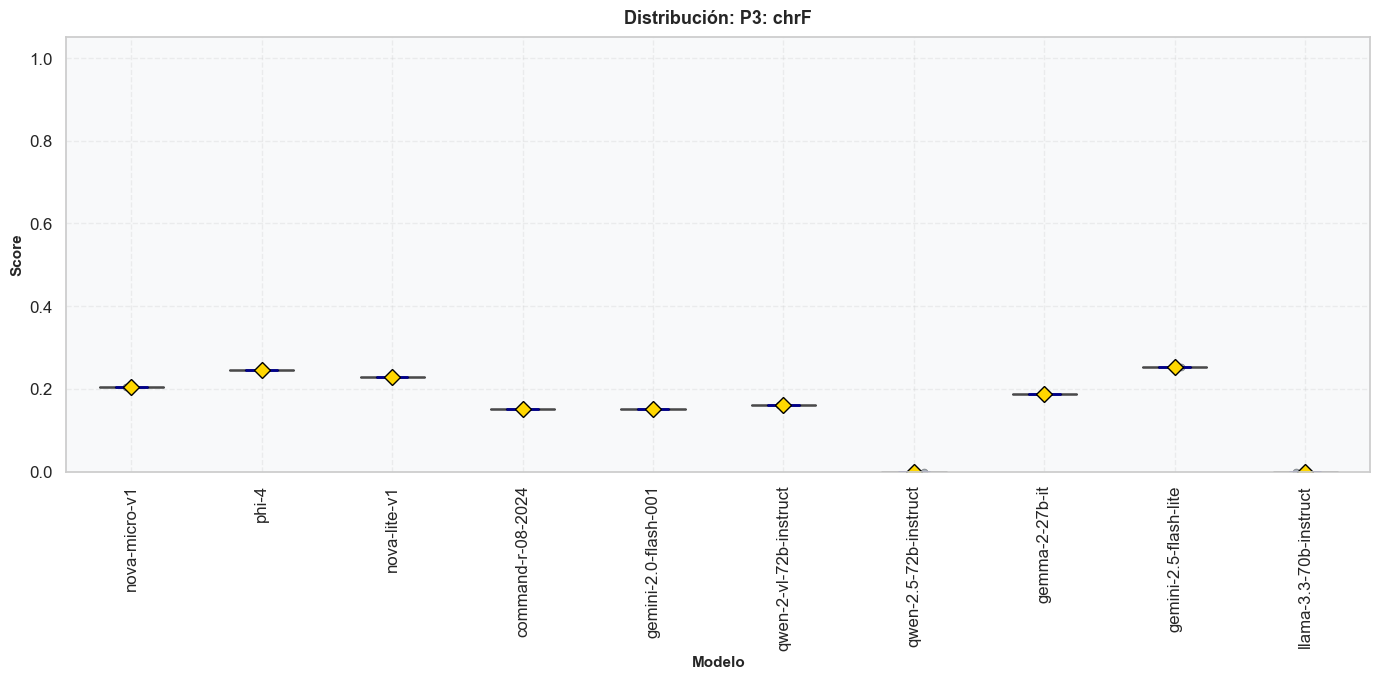

In [5]:
# print("="*80)
# print("Generando diagramas de bigotes...")
# print("="*80)

# Preparar datos para boxplots
boxplot_data = []

for modelo in p1_beto['modelo'].unique():
    modelo_short = modelo.split('/')[-1]
    
    # Prompt 1
    for score in p1_beto[p1_beto['modelo'] == modelo]['f1_score']:
        boxplot_data.append({'Modelo': modelo_short, 'Métrica': 'P1: BETO F1', 'Score': score})
    for score in p1_scibeto[p1_scibeto['modelo'] == modelo]['f1_score']:
        boxplot_data.append({'Modelo': modelo_short, 'Métrica': 'P1: SciBETO F1', 'Score': score})
    for score in p1_sbert[p1_sbert['modelo'] == modelo]['similarity']:
        boxplot_data.append({'Modelo': modelo_short, 'Métrica': 'P1: SBERT', 'Score': score})
    for score in p1_chrf[p1_chrf['modelo'] == modelo]['chrf_score']:
        boxplot_data.append({'Modelo': modelo_short, 'Métrica': 'P1: chrF', 'Score': score})
    
    # Prompt 2
    for is_correct in p2_accuracy[p2_accuracy['modelo'] == modelo]['correcto']:
        boxplot_data.append({'Modelo': modelo_short, 'Métrica': 'P2: Accuracy', 'Score': float(is_correct)})
    
    # Prompt 3
    for score in p3_beto[p3_beto['modelo'] == modelo]['f1_score']:
        boxplot_data.append({'Modelo': modelo_short, 'Métrica': 'P3: BETO F1', 'Score': score})
    for score in p3_scibeto[p3_scibeto['modelo'] == modelo]['f1_score']:
        boxplot_data.append({'Modelo': modelo_short, 'Métrica': 'P3: SciBETO F1', 'Score': score})
    for score in p3_sbert[p3_sbert['modelo'] == modelo]['similarity']:
        boxplot_data.append({'Modelo': modelo_short, 'Métrica': 'P3: SBERT', 'Score': score})
    for score in p3_chrf[p3_chrf['modelo'] == modelo]['chrf_score']:
        boxplot_data.append({'Modelo': modelo_short, 'Métrica': 'P3: chrF', 'Score': score})

df_boxplot = pd.DataFrame(boxplot_data)

# Configuración de estilo profesional
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

# Colores profesionales para cada métrica
metric_colors = {
    'P1: BETO F1': '#3498db',
    'P1: SciBETO F1': '#e74c3c',
    'P1: SBERT': '#2ecc71',
    'P1: chrF': '#f39c12',
    'P3: BETO F1': '#9b59b6',
    'P3: SciBETO F1': '#1abc9c',
    'P3: SBERT': '#e67e22',
    'P3: chrF': '#34495e'
}

# Crear 8 gráficas separadas (una por métrica, excluyendo Accuracy)
metrics_to_plot = ['P1: BETO F1', 'P1: SciBETO F1', 'P1: SBERT', 'P1: chrF',
                   'P3: BETO F1', 'P3: SciBETO F1', 'P3: SBERT', 'P3: chrF']

for idx, metric in enumerate(metrics_to_plot):
    # Crear figura individual para cada métrica
    fig, ax = plt.subplots(figsize=(14, 7))
    
    metric_data = df_boxplot[df_boxplot['Métrica'] == metric]
    modelos_unicos = metric_data['Modelo'].unique()
    
    # Preparar datos para boxplot
    data_by_model = [metric_data[metric_data['Modelo'] == model]['Score'].values 
                     for model in modelos_unicos]
    
    # Crear boxplot con estilo profesional
    bp = ax.boxplot(
        data_by_model,
        tick_labels=[name.replace('_', ' ') for name in modelos_unicos],
        patch_artist=True,
        notch=True,
        showmeans=True,
        meanprops=dict(marker='D', markerfacecolor='gold', markeredgecolor='black', markersize=8)
    )
    
    # Colorear cajas
    color = metric_colors[metric]
    for patch in bp['boxes']:
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Personalizar medianas
    for median in bp['medians']:
        median.set_color('darkblue')
        median.set_linewidth(2)
    
    # Agregar puntos individuales con jitter
    for i, (data, model) in enumerate(zip(data_by_model, modelos_unicos)):
        y = data
        x = np.random.normal(i+1, 0.04, size=len(y))
        ax.scatter(x, y, alpha=0.4, s=25, color=color, edgecolors='black', linewidth=0.5)
    
    ax.set_title(f'Distribución: {metric}', fontsize=13, fontweight='bold', pad=10)
    ax.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax.set_xlabel('Modelo', fontsize=11, fontweight='bold')
    ax.set_ylim([0, 1.05])
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_facecolor('#f8f9fa')
    
    # ROTAR ETIQUETAS DEL EJE X A 90 GRADOS (VERTICAL)
    plt.xticks(rotation=90, ha='center')
    
    plt.tight_layout()
    # plt.savefig(RANKING_OUTPUT_DIR / f'distribucion_{idx+1}_{metric.replace(":", "").replace(" ", "_")}.png', 
    #             dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# print("="*80)
# print(f"✓ Guardados {len(metrics_to_plot)} diagramas de bigotes")
# print("="*80)

## Visualización 4: Ranking General

Ranking basado en cuántas veces cada modelo obtuvo el primer lugar en cada métrica.

In [6]:
# Calcular ranking basado en el score promedio de todas las métricas
ranking_data = []

for modelo_short, scores in metrics_data.items():
    # Calcular promedio general
    all_scores = list(scores.values())
    avg_score = np.mean(all_scores)
    
    # Contar cuántas veces quedó en top 3 por métrica
    top_1_count = 0
    top_3_count = 0
    
    for metric_name in metric_names:
        # Obtener todos los scores para esta métrica
        metric_scores = [(m, metrics_data[m][metric_name]) for m in metrics_data.keys()]
        metric_scores_sorted = sorted(metric_scores, key=lambda x: x[1], reverse=True)
        
        # Verificar posición del modelo actual
        for pos, (m, s) in enumerate(metric_scores_sorted, 1):
            if m == modelo_short:
                if pos == 1:
                    top_1_count += 1
                if pos <= 3:
                    top_3_count += 1
                break
    
    ranking_data.append({
        'Modelo': modelo_short,
        'Score Promedio': round(avg_score, 4),
        'Top 1 (por métrica)': top_1_count,
        'Top 3 (por métrica)': top_3_count,
        'P1: BETO': round(scores['P1: BETO F1'], 3),
        'P1: SciBETO': round(scores['P1: SciBETO F1'], 3),
        'P1: SBERT': round(scores['P1: SBERT'], 3),
        'P1: chrF': round(scores['P1: chrF'], 3),
        'P2: Accuracy': round(scores['P2: Accuracy'], 3),
        'P3: BETO': round(scores['P3: BETO F1'], 3),
        'P3: SciBETO': round(scores['P3: SciBETO F1'], 3),
        'P3: SBERT': round(scores['P3: SBERT'], 3),
        'P3: chrF': round(scores['P3: chrF'], 3)
    })

# Crear DataFrame y ordenar por score promedio
ranking_df = pd.DataFrame(ranking_data)
ranking_df = ranking_df.sort_values('Score Promedio', ascending=False).reset_index(drop=True)
ranking_df['Posición'] = range(1, len(ranking_df) + 1)

# Reordenar columnas para que Posición esté al principio
cols = ['Posición', 'Modelo', 'Score Promedio', 'Top 1 (por métrica)', 'Top 3 (por métrica)'] + \
       [col for col in ranking_df.columns if col not in ['Posición', 'Modelo', 'Score Promedio', 'Top 1 (por métrica)', 'Top 3 (por métrica)']]
ranking_df = ranking_df[cols]

# Aplicar estilos profesionales a la tabla
def highlight_ranking(row):
    """
    Estilo sobrio:
    - Top 1: verde MUY suave
    - Top 2 y 3: gris azulado suave
    - Resto: zebra gris claro
    """
    styles = [''] * len(row)

    if row['Posición'] == 1:
        styles = ['background-color: #e8f5e9; color: #1b5e20; font-weight: 600;'] * len(row)
    elif row['Posición'] in (2, 3):
        styles = ['background-color: #e3f2fd; color: #0d47a1; font-weight: 500;'] * len(row)
    elif row['Posición'] % 2 == 0:
        styles = ['background-color: #f7f7f7; color: #333333;'] * len(row)
    else:
        styles = ['background-color: #ffffff; color: #333333;'] * len(row)

    return styles

styled_df = (
    ranking_df.style
    .apply(highlight_ranking, axis=1)
    .set_properties(**{
        'text-align': 'center',
        'font-size': '10pt',
        'border': '1px solid #d0d0d0',
        'padding': '6px 4px',
        'font-family': 'Segoe UI, Roboto, Arial, sans-serif'
    })
    .set_table_styles([
        {
            'selector': 'thead th',
            'props': [
                ('background-color', '#263238'),
                ('color', 'white'),
                ('font-weight', '600'),
                ('font-size', '10pt'),
                ('text-align', 'center'),
                ('border-bottom', '2px solid #000000'),
                ('padding', '8px 4px')
            ]
        },
        {
            'selector': 'tbody td',
            'props': [
                ('border', '1px solid #e0e0e0')
            ]
        },
        {
            'selector': 'tbody tr:hover',
            'props': [
                ('background-color', '#fffde7')
            ]
        },
        {
            'selector': 'caption',
            'props': [
                ('caption-side', 'top'),
                ('font-size', '13pt'),
                ('font-weight', '600'),
                ('color', '#263238'),
                ('padding', '8px 0'),
                ('text-align', 'left')
            ]
        },
        {
            'selector': 'table',
            'props': [
                ('border-collapse', 'collapse'),
                ('width', '100%')
            ]
        }
    ])
    .set_caption('Ranking general de modelos LLM – Evaluación de modismos colombianos')
)

display(styled_df)

# Guardar como CSV
# ranking_df.to_csv(RANKING_OUTPUT_DIR / 'ranking_general.csv', index=False, encoding='utf-8')

# print("\n" + "="*80)
# print("✓ Ranking guardado exitosamente")
# print("="*80)

,Posición,Modelo,Score Promedio,Top 1 (por métrica),Top 3 (por métrica),P1: BETO,P1: SciBETO,P1: SBERT,P1: chrF,P2: Accuracy,P3: BETO,P3: SciBETO,P3: SBERT,P3: chrF
0,1,qwen-2-vl-72b-instruct,0.661900,2,7,0.717000,0.837000,0.848000,0.311000,1.000000,0.610000,0.778000,0.695000,0.161000
1,2,gemini-2.5-flash-lite,0.625500,3,5,0.495000,0.813000,0.556000,0.323000,1.000000,0.514000,0.835000,0.840000,0.253000
2,3,gemini-2.0-flash-001,0.561900,1,4,0.573000,0.842000,0.614000,0.358000,1.000000,0.330000,0.743000,0.447000,0.150000
3,4,gemma-2-27b-it,0.511600,0,1,0.354000,0.783000,0.389000,0.231000,1.000000,0.363000,0.799000,0.497000,0.188000
4,5,nova-lite-v1,0.449700,0,3,0.418000,0.811000,0.469000,0.216000,0.000000,0.452000,0.765000,0.688000,0.228000
5,6,command-r-08-2024,0.442500,0,1,0.372000,0.800000,0.779000,0.275000,0.000000,0.284000,0.717000,0.604000,0.152000
6,7,nova-micro-v1,0.427400,0,0,0.381000,0.813000,0.540000,0.250000,0.000000,0.334000,0.770000,0.554000,0.205000
7,8,phi-4,0.426600,0,1,0.343000,0.780000,0.496000,0.185000,0.000000,0.436000,0.756000,0.598000,0.246000
8,9,qwen-2.5-72b-instruct,0.411000,3,5,0.594000,0.860000,0.876000,0.369000,1.000000,0.000000,0.000000,0.000000,0.000000
9,10,llama-3.3-70b-instruct,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
